# Ejecución de modelo base

En este notebook se ha seleccionado como base el trabajo presentado por Bing Liu y Ian Lane denominado Attention-Based Recurrent Neural Network Models for Joint Intent Detection
and Slot Filling: https://arxiv.org/pdf/1609.01454.pdf

## 1. Librerías a utilizar

In [51]:
import json
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import Counter
import pickle
%matplotlib inline

In [52]:
# Se verifica si es que el soporte de CUDA está disponible (para utilizar la GPU
# en el cómputo de tensores)
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [53]:
# Se define función para convertir la sequencia de texto a índices en formato de
# tensor con soporte de CUDA
def prepare_sequence(seq, to_ix):
  # Crea una lista a partir de una secuencia. Para cada palabra de la secuencia 
  # asigna un índice de acuerdo al diccionario "to_ix", ya sea que pertenece o 
  # no (token desconocido <UNK>)
  idxs = list(map(lambda w: to_ix[w] if w in to_ix.keys() else to_ix["<UNK>"], seq))
  # Convierte la lista en tensor con soporte de CUDA (si está disponible)
  tensor = Variable(torch.LongTensor(idxs)).cuda() if USE_CUDA else Variable(torch.LongTensor(idxs))
  return tensor

# Se define función para obtener los elementos dentro de las listas de una tupla
flatten = lambda l: [item for sublist in l for item in sublist]

## 2. Carga de los datos y preprocesamiento

El conjunto de entrenamiento se obtiene a partir del siguiente repositorio: https://github.com/yvchen/JointSLU/tree/master/data

In [54]:
# Obtenemos únicamente el archivo que se utilizará
!curl --remote-name -H --location https://raw.githubusercontent.com/yvchen/JointSLU/master/data/atis-2.train.w-intent.iob

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  789k  100  789k    0     0  3670k      0 --:--:-- --:--:-- --:--:-- 3670k


In [55]:
# Cuando se ejecuta en un entorno local indicar correctamente el path general 
# del proyecto:
# path = r'G:\Mi unidad\CLASES\PUCP\2.Clases\Ciclo-II-DL\Proyecto-DL\JoinIntentDetectionSlotFilling\Entregables\Entregable01\RNN-for-Joint-NLU-master'
# train = open(path+"\\"+"\data\\atis-2.train.w-intent.iob","r").readlines()

# Se lee la información del archivo con el corpus de ATIS
train = open('atis-2.train.w-intent.iob', 'r').readlines()
# Se eliminan los saltos de línea al final de la oración
train = [t[:-1] for t in train]
# Se obtiene la secuencia de entrada (oraciones en inglés), la secuencia de 
# salida (secuencia de slots) y la intención relacionada a la secuencia
train = [[t.split('\t')[0].split(' '), t.split('\t')[1].split(' ')[:-1], t.split('\t')[1].split(' ')[-1]] for t in train]
# Se retiran los tokens de inicio y fin en la secuencia de entrada, el token de 
# inicio en la secuencia de salida (ya que se encuentra desfasada una posición 
# respecto a la entrada)
train = [[t[0][1:-1],t[1][1:],t[2]] for t in train]

In [56]:
train[0]

[['i',
  'want',
  'to',
  'fly',
  'from',
  'baltimore',
  'to',
  'dallas',
  'round',
  'trip'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'B-fromloc.city_name',
  'O',
  'B-toloc.city_name',
  'B-round_trip',
  'I-round_trip'],
 'atis_flight']

In [57]:
# Se obtiene las tuplas de las secuencias de entrada, salida y las intenciones 
# por separado
seq_in, seq_out, intent = list(zip(*train))

In [58]:
# Se conforma el vocabulario de las palabras, las etiquetas de los slots y las 
# etiquetas de las intenciones
vocab = set(flatten(seq_in))
slot_tag = set(flatten(seq_out))
intent_tag = set(intent)

In [59]:
# Se establece el tamaño máximo de la secuencia
LENGTH = 50

In [60]:
# Se definen listas para almacenar las secuencias de entrada y salida luego del
# preprocesamiento para añadir tokens de fin de secuencia y para hacer padding
sin = []
sout = []

In [61]:
# Se añade nuevamente el token de fin de secuencia (<EOS>) y se hace padding
# hasta completar el tamaño máximo de secuencia
for i in range(len(seq_in)):
  # Secuencia de entrada
  temp = seq_in[i]
  if len(temp)<LENGTH:
    # Añade el token de fin de secuencia
    temp.append('<EOS>')
    while len(temp)<LENGTH:
      # Completa con token de padding hasta completar tamaño máximo de secuencia
      temp.append('<PAD>')
  else:
    # Trunca la secuencia en el tamaño máximo
    temp = temp[:LENGTH]
    # Reemplaza el último elemento por el token de fin de secuencia
    temp[-1]='<EOS>'
  sin.append(temp)
  
  # Secuencia de salida
  temp = seq_out[i]
  if len(temp)<LENGTH:
    while len(temp)<LENGTH:
      # Completa con token de padding hasta completar tamaño máximo de secuencia
      temp.append('<PAD>')
  else:
    # Trunca la secuencia en el tamaño máximo
    temp = temp[:LENGTH]
    # Reemplaza el último elemento por el token de fin de secuencia
    temp[-1]='<EOS>'
  sout.append(temp)

In [62]:
# Se define un diccionario para mapear las palabras a índices
word2index = {'<PAD>': 0, '<UNK>':1, '<SOS>':2, '<EOS>':3}
for token in vocab:
  if token not in word2index.keys():
    word2index[token]=len(word2index)

# Se invierte el diccionario (para mapear los índices a palabras)
index2word = {v:k for k,v in word2index.items()}

# Se define un diccionario para mapear las etiquetas de slots a índices
tag2index = {'<PAD>' : 0}
for tag in slot_tag:
  if tag not in tag2index.keys():
    tag2index[tag] = len(tag2index)

# Se invierte el diccionario (para mapear los índices a etiquetas de palabras)
index2tag = {v:k for k,v in tag2index.items()}

# Se define un diccionario para mapear las etiquetas de intenciones a índices
intent2index={}
for ii in intent_tag:
  if ii not in intent2index.keys():
    intent2index[ii] = len(intent2index)

# Se invierte el diccionario (para mapear los índices a etiquetas de intenciones)
index2intent = {v:k for k,v in intent2index.items()}

In [63]:
# Se reconstruye una lista general con las listas de secuencias de entrada, 
# salida y las intenciones
train = list(zip(sin, sout, intent))

In [64]:
train[0][2]

'atis_flight'

In [65]:
# Se define una lista vacía para almacenar los tensores con soporte de CUDA 
# correspondientes a las secuencias de entrada, salida y las intenciones
train_data=[]

for tr in train:
  # Se usa la función "prepare_sequence" para obtener el tensor de entrada con
  # soporte de CUDA
  temp = prepare_sequence(tr[0], word2index)
  temp = temp.view(1,-1)
  # Se usa la función "prepare_sequence" para obtener el tensor de salida con
  # soporte de CUDA
  temp2 = prepare_sequence(tr[1], tag2index)
  temp2 = temp2.view(1,-1)
  # Se usa la función "prepare_sequence" para obtener el tensor de intención 
  # con soporte de CUDA
  temp3 = Variable(torch.LongTensor([intent2index[tr[2]]])).cuda() if USE_CUDA else Variable(torch.LongTensor([intent2index[tr[2]]]))
  # Almacena los tensores en una lista
  train_data.append((temp, temp2, temp3))

In [66]:
# Se define una función para producir batches aleatorios del conjunto de 
# entrenamiento 
def getBatch(batch_size, train_data):
  random.shuffle(train_data)
  sindex = 0
  eindex = batch_size
  while eindex < len(train_data):
    batch = train_data[sindex:eindex]
    temp = eindex
    eindex = eindex + batch_size
    sindex = temp
    
    yield batch

## 3. Definición del Modelo

El modelo a trabajar se basa en una Red Neuronal Recurrente con arquitectura Secuencia a Secuencia o seq2seq. Esta consta de un codificador o encoder que recibe la secuencia de entrada, y de un decodificador o decoder que obtiene la secuencia de salida y la intención correspondiente.

In [67]:
class Encoder(nn.Module):
  # Función de inicialización
  def __init__(self, input_size, embedding_size, hidden_size, batch_size=16, n_layers=1):
    super(Encoder, self).__init__()
    # Se inicializa el tamaño de la secuencia de entrada, el tamaño del vector 
    # de embedding, el tamaño del vector de estado oculto, el número de capas y 
    # el tamaño del batch
    self.input_size = input_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.n_layers = n_layers
    self.batch_size=batch_size
    # Se inicializa la capa de embedding y la capa bidireccional LSTM
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, batch_first=True, bidirectional=True)
  
  # Función para inicializar los pesos
  def init_weights(self):
    self.embedding.weight.data.uniform_(-0.1, 0.1)
    # self.lstm.weight.data.
  
  # Función para inicializar con zeros los vectores de estado oculto y de contexto
  def init_hidden(self, input):
    hidden = Variable(torch.zeros(self.n_layers*2, input.size(0), self.hidden_size)).cuda() if USE_CUDA else Variable(torch.zeros(self.n_layers*2, input.size(0), self.hidden_size))
    context = Variable(torch.zeros(self.n_layers*2, input.size(0), self.hidden_size)).cuda() if USE_CUDA else Variable(torch.zeros(self.n_layers*2, input.size(0), self.hidden_size))
    return (hidden, context)
  
  # Función para realizar el cómputo hacia adelante en el codificador
  def forward(self, input, input_masking):
    """
    input : Tensor de entrada
    input_masking : Tensor de entrada enmascarado para los tokens padding
    """
    # Se inicializan los vectores de estado oculto y de contexto
    self.hidden = self.init_hidden(input)
    # La secuencia de entrada pasa a través de la capa de embedding y se 
    # transforma en vector
    embedded = self.embedding(input)
    # Se calcula la salida y los vectores de estado oculto y de contexto a 
    # partir del vector de embedding de la secuencia de entrada
    output, self.hidden = self.lstm(embedded, self.hidden)
    # Vector de salida con el tamaño real de la secuencia (sin padding)
    real_context=[]
    for i, o in enumerate(output):
      real_length = input_masking[i].data.tolist().count(0)
      real_context.append(o[real_length-1])
            
    return output, torch.cat(real_context).view(input.size(0),-1).unsqueeze(1)


In [68]:
class Decoder(nn.Module):
  # Función de inicialización
  def __init__(self,slot_size,intent_size,embedding_size,hidden_size,batch_size=16,n_layers=1,dropout_p=0.1):
    super(Decoder, self).__init__()
    # Se inicializa el tamaño del vector de estado oculto, el número de slots, 
    # el número de intenciones, el tamaño del vector 
    # de embedding, el , el número de capas y 
    # el tamaño del batch
    self.hidden_size = hidden_size
    self.slot_size = slot_size
    self.intent_size = intent_size
    self.n_layers = n_layers
    self.dropout_p = dropout_p
    self.embedding_size = embedding_size
    self.batch_size = batch_size

    # Define the layers
    self.embedding = nn.Embedding(self.slot_size, self.embedding_size) #TODO encoder와 공유하도록 하고 학습되지 않게..

    #self.dropout = nn.Dropout(self.dropout_p)
    self.lstm = nn.LSTM(self.embedding_size+self.hidden_size*2, self.hidden_size, self.n_layers, batch_first=True)
    self.attn = nn.Linear(self.hidden_size,self.hidden_size) # Attention
    self.slot_out = nn.Linear(self.hidden_size*2, self.slot_size)
    self.intent_out = nn.Linear(self.hidden_size*2,self.intent_size)
    
  def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        #self.out.bias.data.fill_(0)
        #self.out.weight.data.uniform_(-0.1, 0.1)
        #self.lstm.weight.data.
    
  def Attention(self, hidden, encoder_outputs, encoder_maskings):
        """
        hidden : 1,B,D
        encoder_outputs : B,T,D
        encoder_maskings : B,T # ByteTensor
        """
        
        hidden = hidden.squeeze(0).unsqueeze(2)  # 히든 : (1,배치,차원) -> (배치,차원,1)
        
        batch_size = encoder_outputs.size(0) # B
        max_len = encoder_outputs.size(1) # T
        energies = self.attn(encoder_outputs.contiguous().view(batch_size*max_len,-1)) # B*T,D -> B*T,D
        energies = energies.view(batch_size,max_len,-1) # B,T,D (배치,타임,차원)
        attn_energies = energies.bmm(hidden).transpose(1,2) # B,T,D * B,D,1 --> B,1,T
        attn_energies = attn_energies.squeeze(1).masked_fill(encoder_maskings,-1e12) # PAD masking
        
        alpha = F.softmax(attn_energies) # B,T
        alpha = alpha.unsqueeze(1) # B,1,T
        context = alpha.bmm(encoder_outputs) # B,1,T * B,T,D => B,1,D
        
        return context # B,1,D
    
  def init_hidden(self,input):
        hidden = Variable(torch.zeros(self.n_layers*1, input.size(0), self.hidden_size)).cuda() if USE_CUDA else Variable(torch.zeros(self.n_layers*2,input.size(0), self.hidden_size))
        context = Variable(torch.zeros(self.n_layers*1, input.size(0), self.hidden_size)).cuda() if USE_CUDA else Variable(torch.zeros(self.n_layers*2, input.size(0), self.hidden_size))
        return (hidden,context)
    
  def forward(self, input,context,encoder_outputs,encoder_maskings,training=True):
        """
        input : B,L(length)
        enc_context : B,1,D
        """
        # Get the embedding of the current input word
        embedded = self.embedding(input)
        hidden = self.init_hidden(input)
        decode=[]
        aligns = encoder_outputs.transpose(0,1)
        length = encoder_outputs.size(1)
        for i in range(length): # Input_sequence와 Output_sequence의 길이가 같기 때문..
            aligned = aligns[i].unsqueeze(1)# B,1,D
            _, hidden = self.lstm(torch.cat((embedded,context,aligned),2), hidden) # input, context, aligned encoder hidden, hidden
            
            # for Intent Detection
            if i==0: 
                intent_hidden = hidden[0].clone() 
                intent_context = self.Attention(intent_hidden, encoder_outputs,encoder_maskings) 
                concated = torch.cat((intent_hidden,intent_context.transpose(0,1)),2) # 1,B,D
                intent_score = self.intent_out(concated.squeeze(0)) # B,D

            concated = torch.cat((hidden[0],context.transpose(0,1)),2)
            score = self.slot_out(concated.squeeze(0))
            softmaxed = F.log_softmax(score)
            decode.append(softmaxed)
            _,input = torch.max(softmaxed,1)
            embedded = self.embedding(input.unsqueeze(1))
            
            # 그 다음 Context Vector를 Attention으로 계산
            context = self.Attention(hidden[0], encoder_outputs,encoder_maskings) 
        # 요고 주의! time-step을 column-wise concat한 후, reshape!!
        slot_scores = torch.cat(decode,1)
        return slot_scores.view(input.size(0)*length,-1), intent_score

# Training

In [69]:
LEARNING_RATE=0.001
EMBEDDING_SIZE=64
HIDDEN_SIZE=64
BATCH_SIZE=16
LENGTH=50
STEP_SIZE=10

In [70]:
encoder = Encoder(len(word2index),EMBEDDING_SIZE,HIDDEN_SIZE)
decoder = Decoder(len(tag2index),len(intent2index),len(tag2index)//3,HIDDEN_SIZE*2)
if USE_CUDA:
    encoder = encoder.cuda()
    decoder = decoder.cuda()
    
encoder.init_weights()
decoder.init_weights()

loss_function_1 = nn.CrossEntropyLoss(ignore_index=0)
loss_function_2 = nn.CrossEntropyLoss()
enc_optim= optim.Adam(encoder.parameters(), lr=LEARNING_RATE)
dec_optim = optim.Adam(decoder.parameters(),lr=LEARNING_RATE)

In [71]:
losess_=[]
for step in range(STEP_SIZE):
    losses=[]
    for i, batch in enumerate(getBatch(BATCH_SIZE,train_data)):
        x,y_1,y_2 = zip(*batch)
        x = torch.cat(x)
        tag_target = torch.cat(y_1)
        intent_target = torch.cat(y_2)
        x_mask = torch.cat([Variable(torch.ByteTensor(tuple(map(lambda s: s ==0, t.data)))).cuda() if USE_CUDA else Variable(torch.ByteTensor(tuple(map(lambda s: s ==0, t.data)))) for t in x]).view(BATCH_SIZE,-1)
        y_1_mask = torch.cat([Variable(torch.ByteTensor(tuple(map(lambda s: s ==0, t.data)))).cuda() if USE_CUDA else Variable(torch.ByteTensor(tuple(map(lambda s: s ==0, t.data)))) for t in tag_target]).view(BATCH_SIZE,-1)
 
        encoder.zero_grad()
        decoder.zero_grad()

        output, hidden_c = encoder(x,x_mask)
        start_decode = Variable(torch.LongTensor([[word2index['<SOS>']]*BATCH_SIZE])).cuda().transpose(1,0) if USE_CUDA else Variable(torch.LongTensor([[word2index['<SOS>']]*BATCH_SIZE])).transpose(1,0)

        tag_score, intent_score = decoder(start_decode,hidden_c,output,x_mask)

        loss_1 = loss_function_1(tag_score,tag_target.view(-1))
        loss_2 = loss_function_2(intent_score,intent_target)

        loss = loss_1+loss_2
        losses.append(loss.data.cpu().numpy() if USE_CUDA else loss.data.numpy())
        loss.backward()

        torch.nn.utils.clip_grad_norm(encoder.parameters(), 5.0)
        torch.nn.utils.clip_grad_norm(decoder.parameters(), 5.0)

        enc_optim.step()
        dec_optim.step()

        if i % 100==0:
            print("Step",step," epoch",i," : ",np.mean(losses))
            losess_.append(np.mean(losses))
            losses=[]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/cuda/Indexing.cu:937.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_

Step 0  epoch 0  :  7.7977247
Step 0  epoch 100  :  3.575982
Step 0  epoch 200  :  2.511451
Step 1  epoch 0  :  2.2060168
Step 1  epoch 100  :  2.0416982
Step 1  epoch 200  :  1.8591514
Step 2  epoch 0  :  1.5543256
Step 2  epoch 100  :  1.3918931
Step 2  epoch 200  :  1.1043189
Step 3  epoch 0  :  0.7935283
Step 3  epoch 100  :  0.9071536
Step 3  epoch 200  :  0.83193743
Step 4  epoch 0  :  0.9652759
Step 4  epoch 100  :  0.6767602
Step 4  epoch 200  :  0.627241
Step 5  epoch 0  :  0.43303567
Step 5  epoch 100  :  0.5274046
Step 5  epoch 200  :  0.46831775
Step 6  epoch 0  :  0.38814506
Step 6  epoch 100  :  0.42927045
Step 6  epoch 200  :  0.40793678
Step 7  epoch 0  :  0.1731962
Step 7  epoch 100  :  0.3286417
Step 7  epoch 200  :  0.32569912
Step 8  epoch 0  :  0.18580785
Step 8  epoch 100  :  0.26348957
Step 8  epoch 200  :  0.26751268
Step 9  epoch 0  :  0.30198938
Step 9  epoch 100  :  0.23272507
Step 9  epoch 200  :  0.226545


In [75]:
def plot_losses(loss):
    plt.plot(loss, label='train')
    plt.legend()
    plt.show()

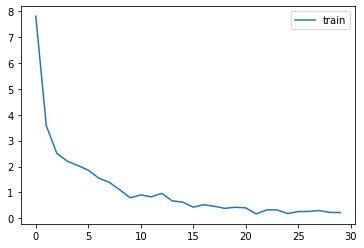

In [76]:
plot_losses(losess_)

# Test

In [77]:
from data import *
from model import Encoder,Decoder

In [78]:
_,word2index,tag2index,intent2index = preprocessing("atis-2.train.w-intent.iob",60)

processed_data_path : /content/data/
Successfully load data. # of set : 4478 
# of vocab : 867, # of slot_tag : 120, # of intent_tag : 21
Preprocessing complete!


In [79]:
index2tag = {v:k for k,v in tag2index.items()}
index2intent = {v:k for k,v in intent2index.items()}

In [80]:
encoder = Encoder(len(word2index),64,64)
decoder = Decoder(len(tag2index),len(intent2index),len(tag2index)//3,64*2)

encoder.load_state_dict(torch.load('jointnlu-encoder.pkl'))
decoder.load_state_dict(torch.load('jointnlu-decoder.pkl'))
if USE_CUDA:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

In [81]:
test = open("atis-2.train.w-intent.iob","r").readlines()
test = [t[:-1] for t in test]
test = [[t.split("\t")[0].split(" "),t.split("\t")[1].split(" ")[:-1],t.split("\t")[1].split(" ")[-1]] for t in test]
test = [[t[0][1:-1],t[1][1:],t[2]] for t in test]

In [83]:
index = random.choice(range(len(test)))
test_raw = test[index][0]
test_in = prepare_sequence(test_raw,word2index)
test_mask = Variable(torch.ByteTensor(tuple(map(lambda s: s ==0, test_in.data)))).cuda() if USE_CUDA else Variable(torch.ByteTensor(tuple(map(lambda s: s ==0, test_in.data)))).view(1,-1)
start_decode = Variable(torch.LongTensor([[word2index['<SOS>']]*1])).cuda().transpose(1,0) if USE_CUDA else Variable(torch.LongTensor([[word2index['<SOS>']]*1])).transpose(1,0)

output, hidden_c = encoder(test_in.unsqueeze(0),test_mask.unsqueeze(0))
tag_score, intent_score = decoder(start_decode,hidden_c,output,test_mask)

v,i = torch.max(tag_score,1)
print("Input Sentence : ",*test[index][0])
print("Truth        : ",*test[index][1])
print("Prediction : ",*list(map(lambda ii:index2tag[ii],i.data.tolist())))
v,i = torch.max(intent_score,1)
print("Truth        : ",test[index][2])
print("Prediction : ",index2intent[i.data.tolist()[0]])

Input Sentence :  i live in denver and i'd like to make a trip to pittsburgh
Truth        :  O O O B-fromloc.city_name O O O O O O O O B-toloc.city_name
Prediction :  I-today_relative B-stoploc.city_name B-stoploc.city_name B-stoploc.city_name B-stoploc.city_name B-stoploc.city_name B-stoploc.city_name B-return_date.month_name B-stoploc.city_name I-toloc.state_name I-arrive_time.time_relative I-arrive_time.time_relative I-arrive_time.time_relative
Truth        :  atis_flight
Prediction :  atis_airline#atis_flight_no


/content/model.py:94: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/cuda/Indexing.cu:937.)
  attn_energies = attn_energies.squeeze(1).masked_fill(encoder_maskings,-1e12) # PAD masking
/content/model.py:96: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = F.softmax(attn_energies) # B,T
/content/model.py:131: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  softmaxed = F.log_softmax(score)


# TODO 

* LSTM forget gate의 bias 1로 고정
* intent decoder의 attention을 독립적인 weight로 구성해보기
* log_softmax 안하고 그냥  crossentropy해보기